In [1]:
using SparseIR
using PyPlot
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["text.usetex"] = true
rcParams["font.family"] = "serif"
rcParams["font.size"] = 16
rcParams["text.latex.preamble"] = raw"\usepackage{amsmath}"
using LinearAlgebra
using Revise
using Optim
using FFTW
using ForwardDiff
include("./Nevanlinna.jl")

calc_functional (generic function with 1 method)

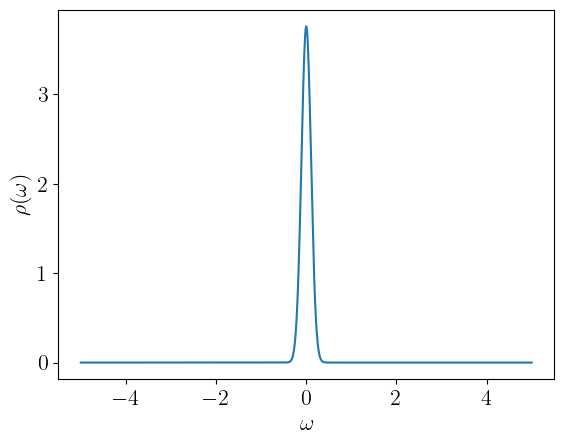

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x14a303c81f70>

In [2]:
# Three Gaussian peaks (normalized to 1)
gaussian(x, mu, sigma) = exp(-((x-mu)/sigma)^2)/(sqrt(π)*sigma)

#rho(omega) = 0.2*gaussian(omega, 0.0, 0.15) + 
#    0.4*gaussian(omega, 1.0, 0.8) + 0.4*gaussian(omega, -1.0, 0.8)

rho(omega) = gaussian(omega, 0.0, 0.15)
#    0.4*gaussian(omega, 1.0, 0.8) + 0.4*gaussian(omega, -1.0, 0.8)


omegas = LinRange(-5, 5, 1000)
plt.xlabel(L"\omega")
plt.ylabel(L"\rho(\omega)")
plt.plot(omegas, rho.(omegas))

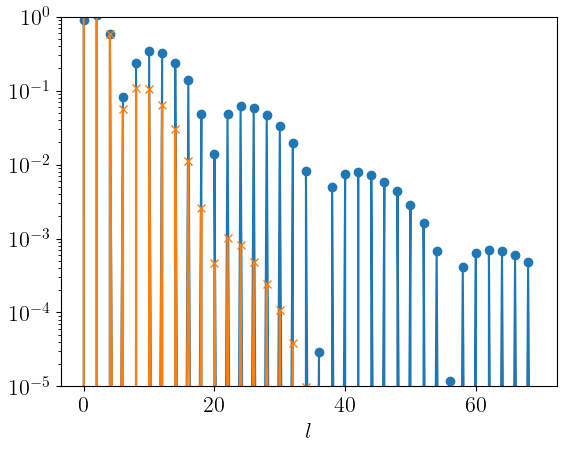

(1.0e-5, 1.0)

In [3]:
beta = 100
wmax = 1000
IR_basis_set = FiniteTempBasisSet(beta, wmax, 1e-7)
#basis = FiniteTempBasis(fermion, beta, wmax, 1e-7)

rhol = [overlap(IR_basis_set.basis_f.v[l], rho) for l in 1:size(IR_basis_set.basis_f)]
gl = - IR_basis_set.basis_f.s .* rhol

plt.semilogy(abs.(rhol), marker="o", label=L"|\rho_l|")
plt.semilogy(abs.(gl), marker="x", label=L"|g_l|")
plt.xlabel(L"l")
plt.ylim([1e-5, 1])
#plt.legend()

In [4]:
gw = evaluate(IR_basis_set.smpl_wn_f, gl)
hnw = Int64(length(IR_basis_set.smpl_wn_f.sampling_points)/2)

37

In [5]:
f = open( "in_green.dat", "w")
for iw in 1:hnw
    IR_basis_set.smpl_wn_f.sampling_points[hnw+iw]
    omega = IR_basis_set.smpl_wn_f.sampling_points[hnw+iw]*pi/beta
    green = gw[hnw+iw]
    println(f, "$omega \t $(real(green)) \t $(imag(green))")
end
close(f)

In [6]:
g = open( "input.txt", "w")
    println(g,"in_green.dat \t $hnw \tout_spec.dat")
close(g)

In [7]:
setprecision(128)

128

In [9]:
test_gw   = Array{Complex{BigFloat}}(undef, hnw) 
test_smpl = Array{BigFloat}(undef, hnw) 
;

In [10]:
for i in 1:hnw
    test_smpl[i]= parse(BigFloat, string(IR_basis_set.smpl_wn_f.sampling_points[hnw+i]*pi/beta))
    test_gw[i]  = parse(BigFloat, string(real(gw[hnw+i]))) + parse(BigFloat, string(imag(gw[hnw+i])))*im
end
#=
f = open("in_green.dat", "r")
for i in 1:hnw
    list = readline(f)
    s  = split(list,'\t')
    o  = parse(BigFloat, s[1])
    re = parse(BigFloat, s[2])
    ii = parse(BigFloat, s[3])
    test_smpl[i] = o
    test_gw[i]   = re + ii*im
end
close(f)
=#

In [26]:
N_imag    =  12
N_real    =  6000
omega_min = -10.0
omega_max =  10.0
eta       =  0.001
H         =  1
ab_coeff = zeros(Float64, 2*H) 
imaginary = ImagDomainData(N_imag, test_smpl, test_gw)
phis = calc_phis(imaginary)
pre_reals = RealDomainData(N_real, omega_min, omega_max, eta)
evaluation(imaginary, pre_reals, phis, H, ab_coeff)
reals = RealDomainData(N_real, omega_min, omega_max, eta)
evaluation(imaginary, reals, phis, H, ab_coeff)
;

Pick matrix is positive semi-definite.


In [27]:
calc_functional(pre_reals)

0.0636420608454371 + 0.0im

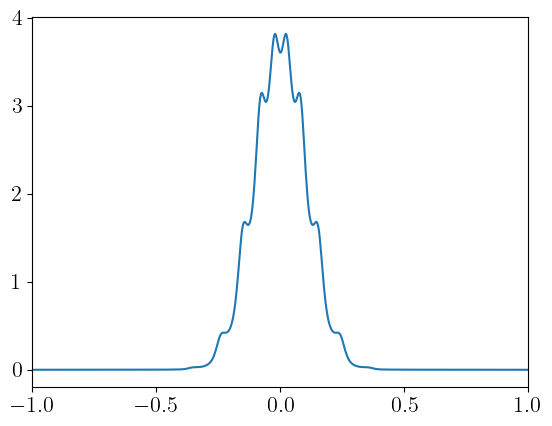

(-1.0, 1.0)

In [38]:
plt.plot(Float64.(real.((pre_reals.freq))), Float64.(imag.(pre_reals.val))/pi)
plt.xlim(-1.0,1.0)

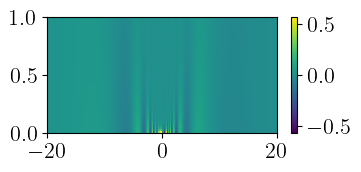

In [31]:
mesh = 1024
myx = 40*(collect(1:mesh) .- mesh/2) ./ mesh
myy = 20*(collect(1:mesh) .- 1) ./ mesh
hardy_plot = Array{Complex{BigFloat}}(undef, mesh, mesh) 
for i in 1:mesh
    for j in 1:mesh
        hardy_plot[j,i] = hardy_basis(myx[j],myy[i],20)
    end
end
plt.figure(figsize=(3.7,1.5))
#plt.pcolormesh(myx, myy, real.(hardy_basis.(myx,myy,1)'), shading="auto")
plt.pcolormesh(myx, myy, Float64.(real.(hardy_plot')))
#plt.pcolormesh(myx, myy, Float64.(imag.(conj.(hardy_plot)')))
ax = plt.gca()
ax.set_xlim([-20,20])
ax.set_ylim([0,1])
#ax.set_aspect("equal")
plt.colorbar()
plt.show()

In [32]:
function functional(imag::ImagDomainData, reals::RealDomainData, phis::Vector{Complex{BigFloat}}, H::Int64, ab_coeff::Vector{Float64})
    evaluation(imaginary, reals, phis, H, ab_coeff)
    return real(calc_functional(reals))
end

functional (generic function with 1 method)

In [33]:
ff = x->functional(imaginary, reals, phis, H, x)

#5 (generic function with 1 method)

In [34]:
@time res = optimize(ff, ab_coeff, BFGS())
#@time res = optimize(ff, ab_coeff, ConjugateGradient())

 37.524264 seconds (698.39 M allocations: 31.862 GiB, 28.99% gc time, 0.99% compilation time)


 * Status: success

 * Candidate solution
    Final objective value:     6.364206e-02

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 1.12e-06 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.84e-01 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.34e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.11e-13 ≰ 0.0e+00
    |g(x)|                 = 7.69e-10 ≤ 1.0e-08

 * Work counters
    Seconds run:   33  (vs limit Inf)
    Iterations:    2
    f(x) calls:    9
    ∇f(x) calls:   9


In [36]:
evaluation(imaginary, reals, phis, H, Optim.minimizer(res))

In [45]:
println(res)

 * Status: success

 * Candidate solution
    Final objective value:     6.364206e-02

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 1.12e-06 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.84e-01 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.34e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.11e-13 ≰ 0.0e+00
    |g(x)|                 = 7.69e-10 ≤ 1.0e-08

 * Work counters
    Seconds run:   33  (vs limit Inf)
    Iterations:    2
    f(x) calls:    9
    ∇f(x) calls:   9



In [42]:
param_f = open( "optim_param.dat", "w")
for i in 1:2*H
    println(param_f, "$(Optim.minimizer(res)[i])")
end
close(param_f)

[9.913875495251655e-7, 1.1368970783840046e-6]


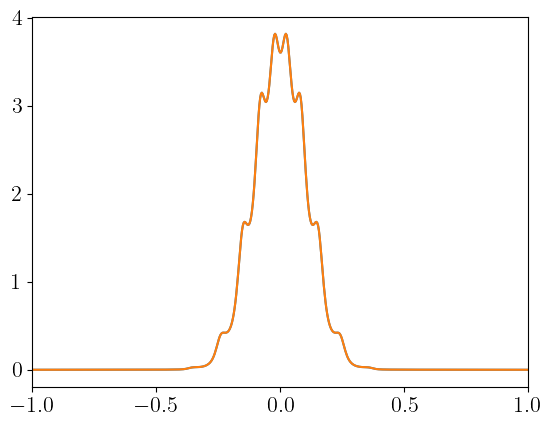

(-1.0, 1.0)

In [37]:
plt.plot(Float64.(real.((reals.freq))), Float64.(imag.(reals.val))/pi)
plt.plot(Float64.(real.((pre_reals.freq))), Float64.(imag.(pre_reals.val))/pi)
plt.xlim(-1.0,1.0)